In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import xgboost
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

**Бинарная классификация диагноза на возможный рак молочной железы: 
M = злокачественный, B = доброкачественный**

Все признаки сгенерированы на основе оцифрованного изображения тонкоигольной аспирационной биопсии груди пациентки. 
Они описывают характеристики ядер клеток, присутствующих на изображении.

In [271]:
data = pd.read_csv('data_breast.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [272]:
data.tail()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,NaN


Нет пропущенных значений, но есть лишние столбцы. Заменим M, B на 1, 0 у целевой переменной diagnosis.

In [273]:
data['diagnosis'] = data['diagnosis'].map({"M": 1, "B": 0})
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [274]:
del data['id'], data['Unnamed: 32']
df_ = data # сохраним датафрейм для графиков

In [275]:
y = data.diagnosis
X = data.drop('diagnosis', axis = 1)
cols = X.columns

In [276]:
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = cols

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

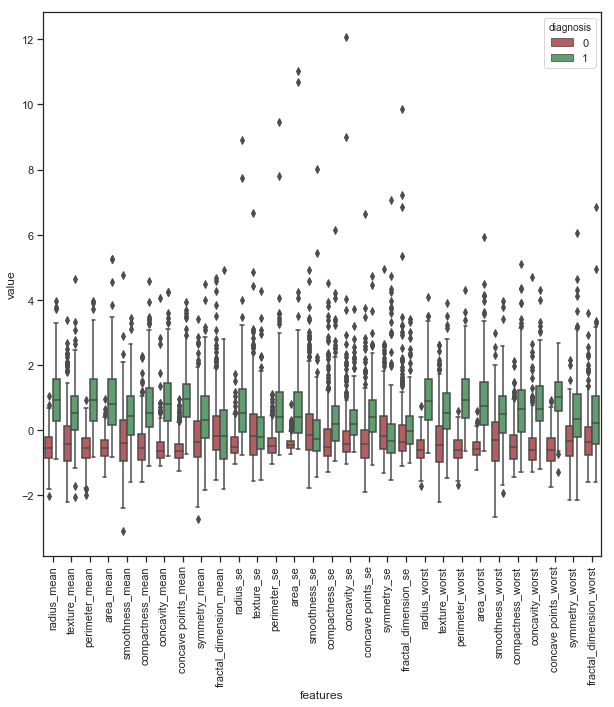

In [277]:
data = X 
data = pd.concat([y,data],axis=1)
data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", palette = ('r','g'), hue="diagnosis", data=data)
plt.xticks(rotation=90)

Из графика видно, что признаки позволят создать довольно точную модель, так как у классов распределения значений слабо пересекаются.

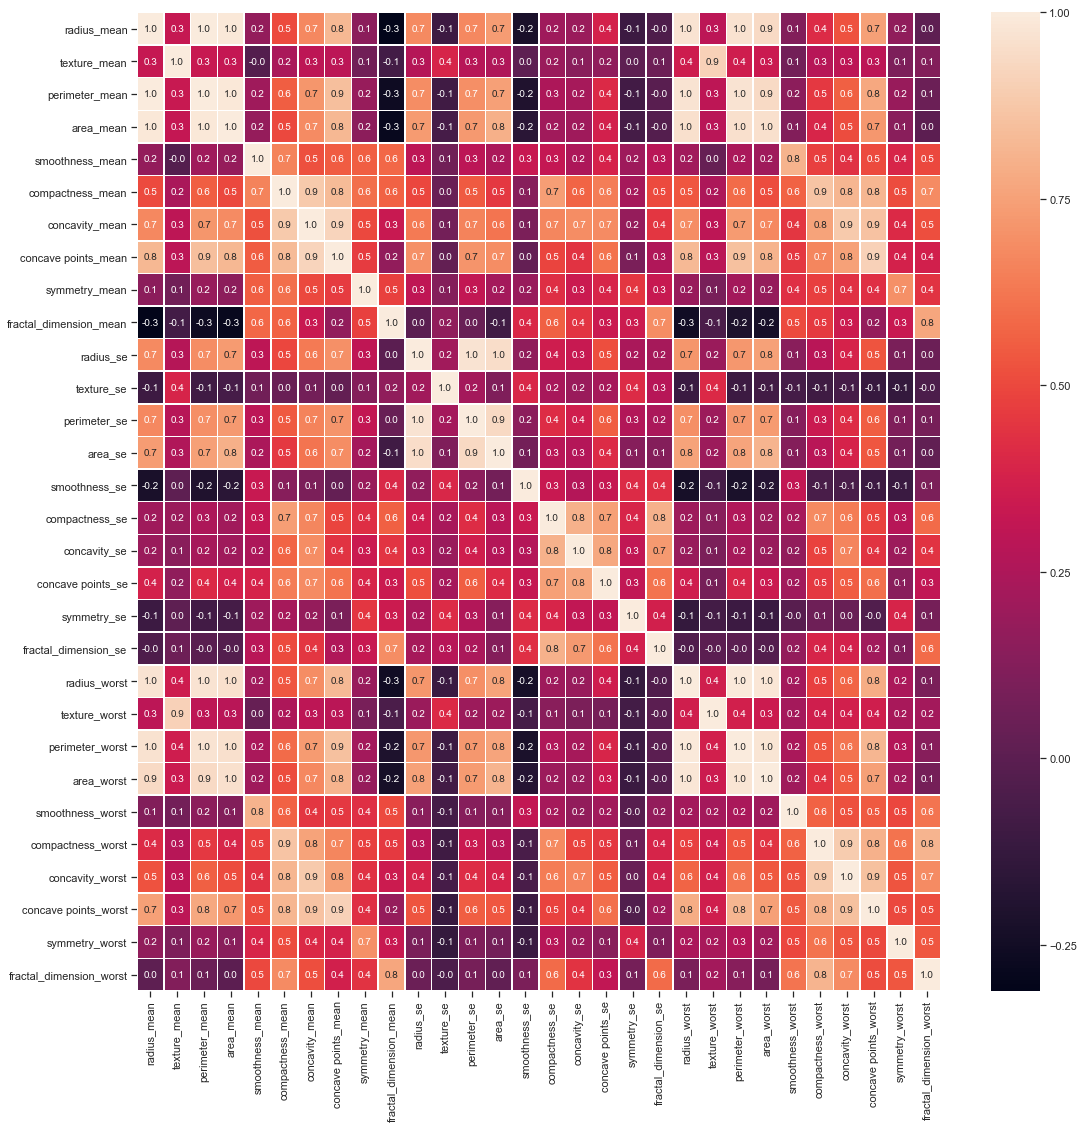

In [278]:
corr = X.corr()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Корреляция между некоторыми признаками очень высокая

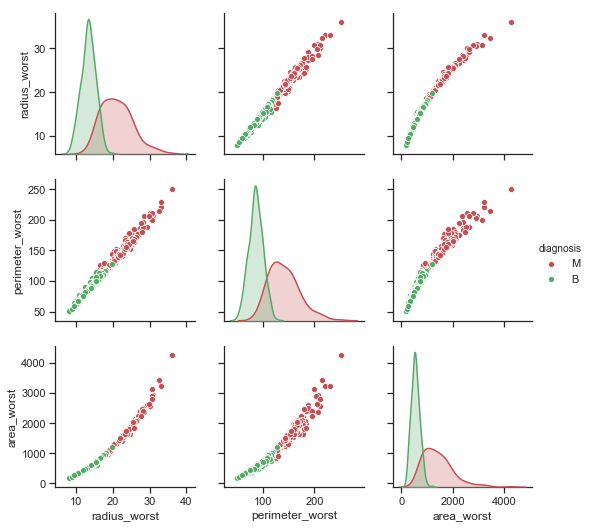

In [181]:
sns.set(style='ticks')
sns.pairplot(df_[['radius_worst','perimeter_worst','area_worst','diagnosis']], palette = ('r','g'), hue ='diagnosis')
plt.show()

In [279]:
stats.ttest_ind(X['radius_worst'], X['perimeter_worst'])

Ttest_indResult(statistic=-7.575993758286635e-15, pvalue=0.999999999999994)

In [280]:
stats.ttest_ind(X['radius_worst'], X['area_worst']) 

Ttest_indResult(statistic=-1.3889321890192164e-14, pvalue=0.9999999999999889)

In [281]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
rfc = RandomForestClassifier()      
rfe = RFE(estimator=rfc, n_features_to_select=10, step=1)
rfe = rfe.fit(x_train, y_train)
print('Chosen best 10 feature by rfe:',x_train.columns[rfe.support_])

Chosen best 10 feature by rfe: Index(['texture_mean', 'perimeter_mean', 'concavity_mean',
       'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst',
       'area_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')


In [283]:
rfc = RandomForestClassifier(random_state=42)      
rfc = rfc.fit(x_train,y_train)

ac = accuracy_score(y_test, rfc.predict(x_test))
print('Accuracy is: ',ac)
confusion_matrix(y_test, rfc.predict(x_test))

Accuracy is:  0.956140350877193


array([[69,  2],
       [ 3, 40]], dtype=int64)

Число записей у классов отличается, поэтому воспользуемся стратегией undersampling/oversampling

In [284]:
data2 = pd.concat([y,X],axis=1)
class_0, class_1 = data2.diagnosis.value_counts()
df_0 = data2[data2['diagnosis'] == 0]
df_1 = data2[data2['diagnosis'] == 1]

In [285]:
class_0, class_1

(357, 212)

Random under-sampling:
1    212
0    212
Name: diagnosis, dtype: int64


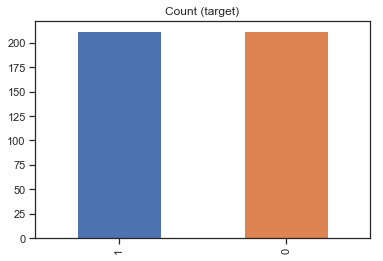

In [286]:
df_0_under = df_0.sample(class_1)
df_under = pd.concat([df_0_under, df_1], axis=0)

print('Random under-sampling:')
print(df_under.diagnosis.value_counts())

df_under.diagnosis.value_counts().plot(kind='bar', title='Count (target)');

In [287]:
y = df_under.diagnosis
X = df_under.drop('diagnosis', axis = 1)
cols = X.columns

In [288]:
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = cols
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [289]:
rfc = RandomForestClassifier(random_state=42)      
rfc = rfc.fit(x_train,y_train)

ac = accuracy_score(y_test, rfc.predict(x_test))
print('Accuracy is: ',ac)
confusion_matrix(y_test, rfc.predict(x_test))

Accuracy is:  0.9411764705882353


array([[33,  5],
       [ 0, 47]], dtype=int64)

Точность немного уменьшилась, что происходит всегда при выравнивании числа записей разных классов

Random over-sampling:
1    357
0    357
Name: diagnosis, dtype: int64


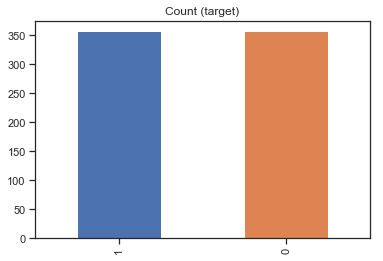

In [290]:
df_1_over = df_1.sample(class_0, replace=True)
df_over = pd.concat([df_0, df_1_over], axis=0)

print('Random over-sampling:')
print(df_over.diagnosis.value_counts())

df_over.diagnosis.value_counts().plot(kind='bar', title='Count (target)');

In [291]:
y = df_over.diagnosis
X = df_over.drop('diagnosis', axis = 1)
cols = X.columns

In [292]:
scaler = StandardScaler().fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = cols
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 30 columns):
radius_mean                714 non-null float64
texture_mean               714 non-null float64
perimeter_mean             714 non-null float64
area_mean                  714 non-null float64
smoothness_mean            714 non-null float64
compactness_mean           714 non-null float64
concavity_mean             714 non-null float64
concave points_mean        714 non-null float64
symmetry_mean              714 non-null float64
fractal_dimension_mean     714 non-null float64
radius_se                  714 non-null float64
texture_se                 714 non-null float64
perimeter_se               714 non-null float64
area_se                    714 non-null float64
smoothness_se              714 non-null float64
compactness_se             714 non-null float64
concavity_se               714 non-null float64
concave points_se          714 non-null float64
symmetry_se                714 

In [293]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [294]:
model = RandomForestClassifier(random_state=42)      
model = model.fit(x_train,y_train)

ac = accuracy_score(y_test, model.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test, model.predict(x_test))
cm

Accuracy is:  0.9790209790209791


array([[75,  1],
       [ 2, 65]], dtype=int64)

**Oversampling показал хорошие результаты**

**PCA**

Text(0, 0.5, 'explained_variance_ratio_')

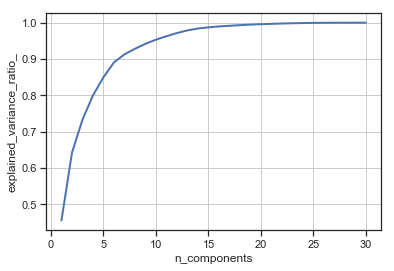

In [295]:
pca = PCA().fit(X)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Снизим размерность до 20 компонент и обучим модель.

In [296]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 20 columns):
0     714 non-null float64
1     714 non-null float64
2     714 non-null float64
3     714 non-null float64
4     714 non-null float64
5     714 non-null float64
6     714 non-null float64
7     714 non-null float64
8     714 non-null float64
9     714 non-null float64
10    714 non-null float64
11    714 non-null float64
12    714 non-null float64
13    714 non-null float64
14    714 non-null float64
15    714 non-null float64
16    714 non-null float64
17    714 non-null float64
18    714 non-null float64
19    714 non-null float64
dtypes: float64(20)
memory usage: 111.6 KB


In [298]:
kfold = KFold(n_splits=5, random_state=42)

In [299]:
LogReg = LogisticRegression()
results = cross_val_score(LogReg, X_pca, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0
))

Accuracy: 95.936% (1.130%)


In [300]:
from sklearn.svm import SVC
svecm = SVC()
results = cross_val_score(svecm, X_pca, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 96.354% (1.915%)


In [301]:
from sklearn.tree import DecisionTreeClassifier
destree = DecisionTreeClassifier()
results = cross_val_score(destree, X_pca, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0
))

Accuracy: 93.694% (3.376%)


In [316]:
import xgboost
xgb = xgboost.XGBClassifier(max_depth=3, random_seed = 42, n_jobs=-1)
results = cross_val_score(xgb, X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0
))

Accuracy: 97.201% (1.168%)


In [317]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier(max_depth=3, random_seed = 42, n_jobs=-1)
results = cross_val_score(lgb, X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0
))

Accuracy: 97.479% (1.441%)


Lightgbm показал немного точнее результаты при той же глубине дерева.

Precision, recall, f1, support

In [321]:
from sklearn.metrics import classification_report
model = LogReg
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.2,
random_state=43)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        76
           1       0.98      0.94      0.96        67

   micro avg       0.97      0.97      0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



In [323]:
predicted_proba_LogReg = model.predict_proba(X_pca)
predicted_proba_LogReg[:10].round(3)

array([[0.91 , 0.09 ],
       [0.996, 0.004],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.988, 0.012],
       [0.636, 0.364],
       [0.998, 0.002],
       [0.998, 0.002],
       [0.999, 0.001]])

In [325]:
y_prob = predicted_proba_LogReg[:, 0]
print("Brier_score: %.3f%% " % (brier_score_loss(y, y_prob)))

Brier_score: 0.929% 


In [326]:
model = svecm
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.2, random_state=43)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        76
           1       0.96      0.96      0.96        67

   micro avg       0.96      0.96      0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



In [330]:
model = destree
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.2, random_state=43)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        76
           1       0.94      0.93      0.93        67

   micro avg       0.94      0.94      0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



In [331]:
model = xgb
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,
random_state=43)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        76
           1       0.99      0.99      0.99        67

   micro avg       0.99      0.99      0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



In [332]:
predicted_proba_xgb = model.predict_proba(X)
predicted_proba_xgb[:10].round(3)

array([[0.996, 0.004],
       [0.999, 0.001],
       [0.999, 0.001],
       [0.995, 0.005],
       [0.999, 0.001],
       [0.996, 0.004],
       [0.933, 0.067],
       [0.996, 0.004],
       [0.998, 0.002],
       [0.996, 0.004]], dtype=float32)

In [333]:
y_prob = predicted_proba_xgb[:, 0]
print("Оценка Бриера: %.3f%% " % (brier_score_loss(y, y_prob)))

Оценка Бриера: 0.976% 


In [334]:
model = lgb
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2,
random_state=43)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        76
           1       1.00      0.97      0.98        67

   micro avg       0.99      0.99      0.99       143
   macro avg       0.99      0.99      0.99       143
weighted avg       0.99      0.99      0.99       143



In [335]:
predicted_proba_lgb = model.predict_proba(X)
predicted_proba_lgb[:10].round(3)

array([[0.998, 0.002],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.998, 0.002],
       [0.957, 0.043],
       [1.   , 0.   ],
       [1.   , 0.   ],
       [0.999, 0.001]])

In [336]:
y_prob = predicted_proba_lgb[:, 0]
print("Оценка Бриера: %.3f%% " % (brier_score_loss(y, y_prob)))

Оценка Бриера: 0.987% 


Метод машинного обучения LGBM в данном кейсе показал наилучшие результаты.